## Comparing Algorithms for Spam Classification in an Imbalanced Dataset  Alex Arbisman

We all know that spam messages can be incredibly annoying and that they often have very different message content than regular messages/emails. For these reasons, there's a lot of incentive in creating an automatic way to filter out spam messages from regular ones. Pretty much every email provider employs some kind of spam detection algorithm. For this project, I attempt to build a similar spam detection algorithm on a dataset of roughly 5,300 messages and see which statistical algorithm works best for spam detection.

In [496]:
## The main ones
import numpy as np
import pandas as pd

## Data Vizualization
import matplotlib.pyplot as plt
import seaborn as sns

## NLP
import nltk
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

## Machine Learning (SKlearn)
# Data Transformation/Prep
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Scoring
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## Misc
from operator import itemgetter

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arbis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 0: Loading the data and removing nulls

In [534]:
dat = pd.read_csv('data/data.csv')

print(dat.shape[0], 'rows in the data set')

5330 rows in the data set


In [498]:
## There are only 2 blank messeges, we'll remove them
print('Blank Messeges:', sum(dat['text'].apply(lambda x: len(nltk.word_tokenize(x))) == 0))
dat = dat[dat['text'].apply(lambda x: len(nltk.word_tokenize(x))) != 0]

Blank Messeges: 2


## Part 1 data exploration

### There is a pretty heavy class imbalance in this data set.

There's roughly 4,600 non-spam emails and 700 spam emails. Meaning that spam emails only make up ~13% of the dataset.
We need to keep a few things in consideration when we proceed to modeling:

#### Accuracy/Error is not a good metric for classification
This is because classifiers tend predict the entire data set to be the majority class when there is class imbalance. As a result, a high accuracy/low error might be that significant (accuracy paradox).


#### If we want to do some sort of n-fold cross validation (we do), then we need to take stratified samples of the data.
Due to the low number of spam emails, if we take a sample for crossvalidation, then we run the risk of having even smaller percentages of the minority class, making that model even less applicable to the full data.

711 Spam emails
4617 Non-spam emails


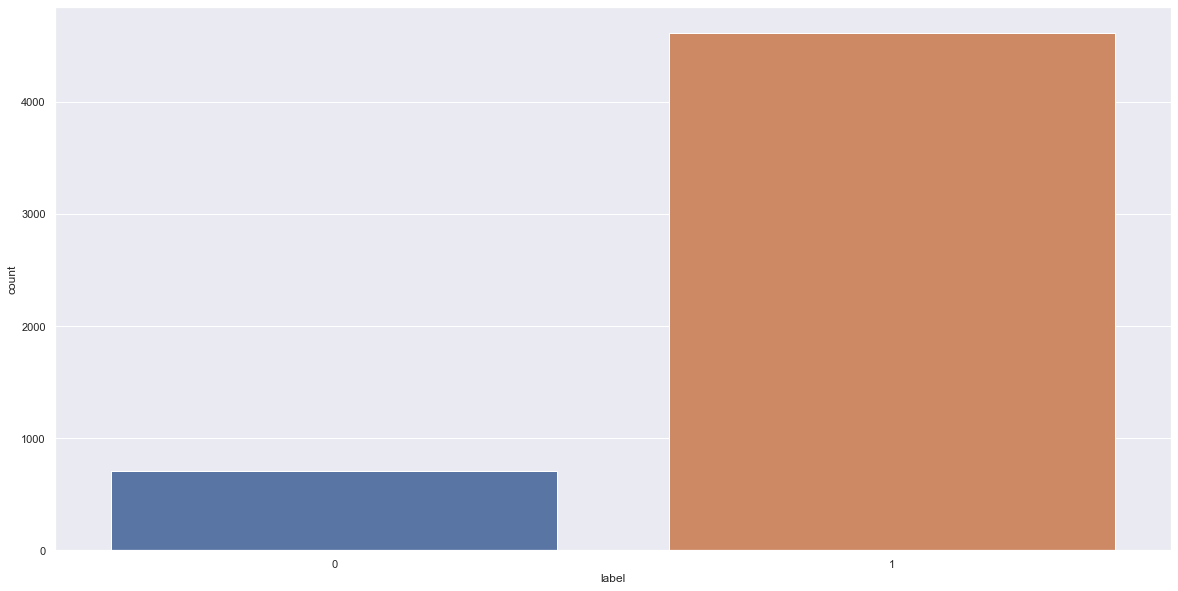

In [499]:
sns.countplot(data=dat, x = 'label')
print(sum(dat.label == 0), 'Spam emails')
print(sum(dat.label == 1), 'Non-spam emails')

#### Messege Length Comparison

Average Character Length for spam messeges: 138.27
Average Character Length for legitimate messeges: 71.31


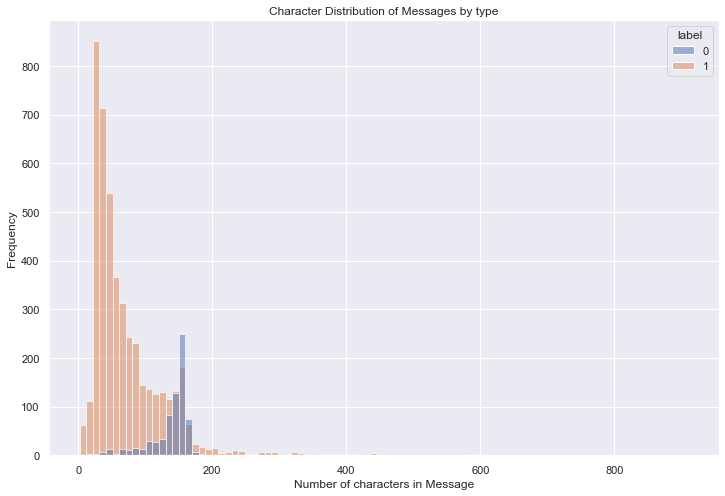

In [533]:
## Set up our histogram
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data=dat, x=dat['text'].str.len(), hue = 'label')

plt.xlabel('Number of characters in Message')
plt.ylabel('Frequency')
plt.title('Character Distribution of Messages by type')

## Get our average messege lengths
avg_spam_len = round(np.mean(dat[dat['label'] == 0]['text'].str.len()), 2)
avg_legit_len = round(np.mean(dat[dat['label'] == 1]['text'].str.len()), 2)

print('Average Character Length for spam messeges:', avg_spam_len)
print('Average Character Length for legitimate messeges:', avg_legit_len)

#### Word/Token Distribution

Average number of words for spam messeges: 24.98
Average number of words for legitimate messeges: 14.78


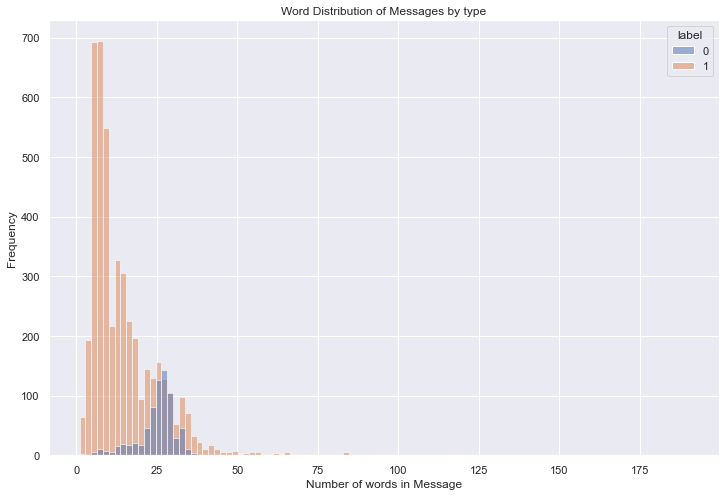

In [532]:
## Set up our histogram
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data=dat, x=dat['text'].apply(lambda x:len(nltk.word_tokenize(x))), hue = 'label')

plt.xlabel('Number of words in Message')
plt.ylabel('Frequency')
plt.title('Word Distribution of Messages by type')

## Get our average messege lengths
avg_tokens_spam = round(np.mean(dat[dat['label'] == 0]['text'].apply(lambda x:len(nltk.word_tokenize(x)))), 2)
avg_tokens_legit = round(np.mean(dat[dat['label'] == 1]['text'].apply(lambda x:len(nltk.word_tokenize(x)))), 2)

print('Average number of words for spam messeges:', avg_tokens_spam)
print('Average number of words for legitimate messeges:', avg_tokens_legit)

Average number of non-stopwords for spam messeges: 17.79
Average number of non-stopwords for legitimate messeges: 8.27


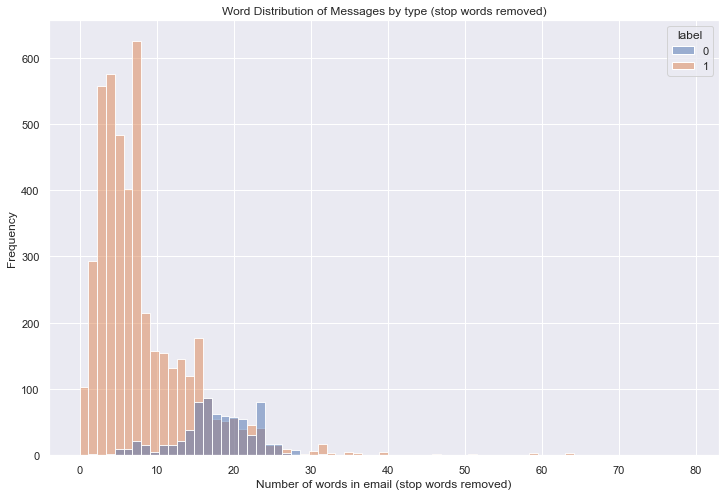

In [502]:
stop_words = set(stopwords.words('english'))

## Set up our histogram
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data=dat, x=dat['text'].apply(lambda x:len([word for word in nltk.word_tokenize(x) if word not in stop_words])), hue = 'label')

plt.xlabel('Number of words in email (stop words removed)')
plt.ylabel('Frequency')
plt.title('Word Distribution of Messages by type (stop words removed)')

## Get our average messege non-stopword length
avg_tokens_spam_ns = round(np.mean(dat[dat['label'] == 0]['text'].apply(lambda x:len([word for word in nltk.word_tokenize(x) if word not in stop_words]))), 2)
avg_tokens_legit_ns = round(np.mean(dat[dat['label'] == 1]['text'].apply(lambda x:len([word for word in nltk.word_tokenize(x) if word not in stop_words]))), 2)

print('Average number of non-stopwords for spam messeges:', avg_tokens_spam_ns)
print('Average number of non-stopwords for legitimate messeges:', avg_tokens_legit_ns)

#### Stopword distribution as a proportion of total words

Average non-stopwords ratio for spam messeges: 0.71
Average non-stopwords ratio for legitimate messeges: 0.58


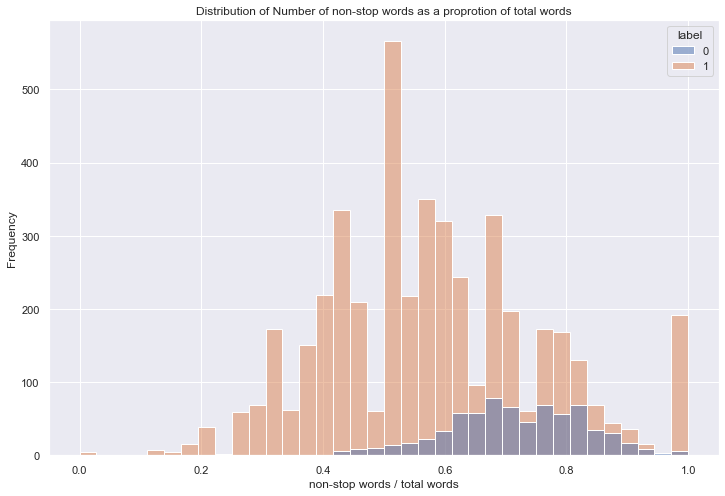

In [503]:
def nonstopword_ratio(text, stop_words):
    
    ## Get the word count and stopword count
    total_words = len(nltk.word_tokenize(text))
    nonstop_words = len([word for word in nltk.word_tokenize(text) if word not in stop_words])
    
    ## Return the ratio
    return round(nonstop_words/total_words, 3)
    
## Set up our histogram
fig, ax = plt.subplots(figsize=(12,8))
sns.histplot(data=dat, x=dat['text'].apply(lambda x: nonstopword_ratio(x, stop_words)), hue = 'label')

plt.xlabel('non-stop words / total words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of non-stop words as a proprotion of total words')

## Get our average messege non-stopword ratio
ns_ratio_spam = round(np.mean(dat[dat['label'] == 0]['text'].apply(lambda x: nonstopword_ratio(x, stop_words))), 2)
ns_ratop_legit = round(np.mean(dat[dat['label'] == 1]['text'].apply(lambda x: nonstopword_ratio(x, stop_words))), 2)

print('Average non-stopwords ratio for spam messeges:', ns_ratio_spam)
print('Average non-stopwords ratio for legitimate messeges:', ns_ratop_legit)

### Finding the top 10 most used words, by messege type

In [504]:
## We build a pipeline to lemmatize each messege
lemmatizer = WordNetLemmatizer()

def process_text(text, lemmatizer, stop_words):
    
    ## first we turn it to lowercase
    text = text.lower()
        
    ## Convert to word tokens
    text = nltk.word_tokenize(text)
    
    ## remove stopwrods
    text = [word for word in text if word not in stop_words]
    
    ## lemmatize the words
    text = [lemmatizer.lemmatize(word) for word in text]
    
    ## return it to a string
    output_text = ' '.join(text)
    
    return output_text
    
dat['processed_text'] = dat['text'].apply(lambda x: process_text(x, lemmatizer, stop_words))

In [505]:
## We make a spam corpus of every word in the processed text list
spam_corpus = []
for text in dat[dat['label'] == 0]['processed_text'].tolist():
    
    for word in text.split():
        spam_corpus.append(word)

## We create a word:count dictionary using the corpus
spam_dict = {}
for word in spam_corpus:
    
    if word in spam_dict:
        spam_dict[word] += 1
        
    elif word not in spam_dict:
        spam_dict[word] = 1
        
    
legit_corpus = []
for text in dat[dat['label'] == 1]['processed_text'].tolist():
    
    for word in text.split():
        legit_corpus.append(word)
        
legit_dict = {}
for word in legit_corpus:
    
    if word in legit_dict:
        legit_dict[word] += 1
        
    elif word not in legit_dict:
        legit_dict[word] = 1 
        
top_10_legit = dict(sorted(legit_dict.items(), key = itemgetter(1), reverse = True)[:10])
top_10_spam = dict(sorted(spam_dict.items(), key = itemgetter(1), reverse = True)[:10])

[Text(0.5, 1.0, 'Top 10 words and their frequencies in all Spam Messeges')]

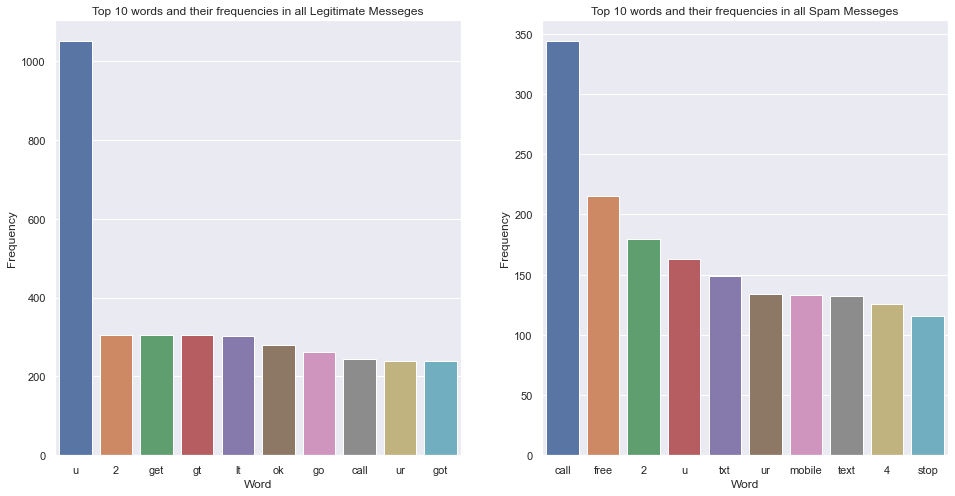

In [506]:
## Set up our plot
f, axes = plt.subplots(1, 2, figsize=(16,8))

## Get the keys
legit_keys = list(top_10_legit.keys())

# get values in the same order as keys
legit_vals = [top_10_legit[k] for k in legit_keys]
sns.barplot(x=legit_keys, y=legit_vals, ax = axes[0])


## Get the keys
spam_keys = list(top_10_spam.keys())

# get values in the same order as keys
spam_vals = [top_10_spam[k] for k in spam_keys]
sns.barplot(x=spam_keys, y=spam_vals, ax = axes[1])


## Formatting
plt.setp(axes[0:], xlabel='Word')
plt.setp(axes[0:], ylabel='Frequency')
plt.setp(axes[0], title='Top 10 words and their frequencies in all Legitimate Messeges')
plt.setp(axes[1], title='Top 10 words and their frequencies in all Spam Messeges')

### Insights from Data
#### Messege length distributions:
We see that spam messeges are routinely longer than legitimate messeges (in terms of character length, word length, and non-stopwords length) and have a higher frequency of non-stop words.

#### Top words by messege type:
This distribution looks as expected. There are a few common words that overlap between legitimate messeges and spam messeges (U, 2, call, ur), the words free, mobile, text are a lot more frequent in spam messeges than in legitimate ones. Legitimate messeges are pretty common words, though I don't know what 'gt' means. (An acronym website is saying either "get together", "girl talk" or "google toolbar"...its probably the last one).

## Part 2 Data Preprocessing/Feature Creation


#### Feature Creation

In [507]:
## Get the total number of chars in the original message
dat['num_chars'] = dat['text'].str.len()

## Get the total number of words in the original message
dat['num_words'] = dat['text'].apply(lambda x:len(nltk.word_tokenize(x)))

## Get the total number of non-stopwords in the original message
dat['num_ns_words'] = dat['text'].apply(lambda x:len([word for word in nltk.word_tokenize(x) if word not in stop_words]))

## Get the ratio of non-stop words to total words
dat['nonstop_ratio'] = x=dat['text'].apply(lambda x: nonstopword_ratio(x, stop_words))

dat.head()

,text,label,processed_text,num_chars,num_words,num_ns_words,nonstop_ratio
0,i m in solihull | do you want anything,1,solihull | want anything,40,9,4,0.444
1,gud mrng dear hav a nice day,1,gud mrng dear hav nice day,28,7,6,0.857
2,dude how do you like the buff wind,1,dude like buff wind,35,8,4,0.500
3,yup wun believe wat u really neva c e msg i ...,1,yup wun believe wat u really neva c e msg sent...,58,13,12,0.923
4,did you get any gift this year i didnt get an...,1,get gift year didnt get anything bad,60,13,7,0.538


In [508]:
## Creating a custom Text Processor is the easiest way to encorporate the TFidfectorizer
class TextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.TextProcessor = Pipeline(steps=[
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2)))    ])
       
        
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
       
        return  self.TextProcessor.fit_transform(X.squeeze()).toarray()

In [509]:
## Getting the Data ready
response_var = 'label'
continous_features = ['num_chars','num_words','num_ns_words','nonstop_ratio']
text_feature = ['processed_text']

independant_vars = continous_features + text_feature

## For our continous data, we will use a standard scaler and tfidf transform our text data
continous_transformer = StandardScaler()
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

## We place everything into a column transformer to make things easier
preprocessor = ColumnTransformer(
    transformers=[
        ("cont", continous_transformer, continous_features),
        ("text", TextProcessor(), text_feature),
    ]
)

## and create our final modeling variables
X = dat[independant_vars]
y = dat[response_var]

## And doublecheck that our rows match up
print(sum(dat['label'] != y), 'rows out of place (response var)')
print((dat[['processed_text','num_chars','num_words','num_ns_words','nonstop_ratio']] != X[['processed_text','num_chars','num_words','num_ns_words','nonstop_ratio']]).values.sum(), 'Values out of place (independant vars)')


0 rows out of place (response var)
0 Values out of place (independant vars)


In [510]:
## Create our final dataset by transforming our dataset
X = preprocessor.fit_transform(X)

## Part 3: Modedling

Our modeling will follow this pattern:

Step 1: Do a cross-validation based grid search to get the best hyperparameters for maximizing precision

Step 2: Fit a model with those optimal hyperparameters

Step 3: Set up a stratefied K-fold sample of the data (to handle class imbalance)

Step 4: Get the Average Percision, Recall, F1, and Accuracy for each optimized model


#### Note: I'm commenting out the cross validation becase it took days to run on my machine

#### Logistic Regression

In [511]:
# ## Create our Logistic Regression Object with the hardcoded parameters
# lr = LogisticRegression(random_state = 0, solver = 'saga')

# ## Create our parameter grid and set up our gridsearch
# lr_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#             'C':[0.01, 0.1, 0.5, 1]}

# lr_grid = GridSearchCV(lr, lr_params, cv = 5, scoring = 'precision', verbose = 2)


# ## Fit our gridsearch object and get up our best parameters
# lr_grid.fit(X, y)

# lr_best = lr_grid.best_params_

# print(lr_best)

# Best params: {'C': 0.01, 'penalty': 'none'}

In [512]:
## We set up our model using the best parameters that we had from our grid search
lr_best = LogisticRegression(random_state = 0, solver = 'lbfgs', penalty = 'none')

## Set up our Stratified K-folds 
skf = StratifiedKFold(n_splits=10)

## For each fold, we set up our train and test data, fit our model, get predictions, and create a precision/f1 score
lr_precisions = {}
lr_recalls = {}
lr_accuracies = {}
lr_f1s = {}

fold_no = 1
for train_index, test_index in skf.split(X, y):
    
    ## Get the proper data and fit the model
    print('Running Fold No:', fold_no)
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.values[train_index]
    y_test = y.values[test_index]
    
    lr_best.fit(X_train, y_train)
    lr_predictions = lr_best.predict(X_test)
    
    ## Get the corresponding fold score, and add it to the dictionary
    fold_precision = precision_score(y_test,lr_predictions)
    lr_precisions[fold_no] = fold_precision
    print('Fold',str(fold_no),'Precision:', round(fold_precision, 4))
    
    fold_recall = recall_score(y_test,lr_predictions)
    lr_recalls[fold_no] = fold_recall
    print('Fold',str(fold_no),'Recall:', round(fold_recall, 4))
    
    fold_accuracy = accuracy_score(y_test,lr_predictions)
    lr_accuracies[fold_no] = fold_accuracy
    print('Fold',str(fold_no),'Accuracy:', round(fold_accuracy, 4))
    
    fold_f1 = f1_score(y_test,lr_predictions)
    lr_f1s[fold_no] = fold_f1
    print('Fold',str(fold_no),'f1:',round(fold_f1, 4))
    
    print()
    fold_no += 1

Running Fold No: 1
Fold 1 Precision: 0.9893
Fold 1 Recall: 0.9978
Fold 1 Accuracy: 0.9887
Fold 1 f1: 0.9935

Running Fold No: 2
Fold 2 Precision: 0.9957
Fold 2 Recall: 1.0
Fold 2 Accuracy: 0.9962
Fold 2 f1: 0.9978

Running Fold No: 3
Fold 3 Precision: 0.985
Fold 3 Recall: 0.9978
Fold 3 Accuracy: 0.985
Fold 3 f1: 0.9914

Running Fold No: 4
Fold 4 Precision: 0.9935
Fold 4 Recall: 0.9935
Fold 4 Accuracy: 0.9887
Fold 4 f1: 0.9935

Running Fold No: 5
Fold 5 Precision: 0.9745
Fold 5 Recall: 0.9935
Fold 5 Accuracy: 0.9719
Fold 5 f1: 0.9839

Running Fold No: 6
Fold 6 Precision: 0.9787
Fold 6 Recall: 0.9935
Fold 6 Accuracy: 0.9756
Fold 6 f1: 0.986

Running Fold No: 7
Fold 7 Precision: 0.9893
Fold 7 Recall: 1.0
Fold 7 Accuracy: 0.9906
Fold 7 f1: 0.9946

Running Fold No: 8
Fold 8 Precision: 0.9829
Fold 8 Recall: 1.0
Fold 8 Accuracy: 0.985
Fold 8 f1: 0.9914

Running Fold No: 9
Fold 9 Precision: 0.9829
Fold 9 Recall: 0.9957
Fold 9 Accuracy: 0.9812
Fold 9 f1: 0.9892

Running Fold No: 10
Fold 10 Prec

In [513]:
print("Logistic Regression Performance:")
print("Average Precision:" ,round(np.mean(list(lr_precisions.values())), 4))
print("Average Recall:" ,round(np.mean(list(lr_recalls.values())), 4))
print("Average Accuracy:" ,round(np.mean(list(lr_accuracies.values())), 4))
print("Average F1:" ,round(np.mean(list(lr_f1s.values())), 4))

Logistic Regression Performance:
Average Precision: 0.9857
Average Recall: 0.9963
Average Accuracy: 0.9842
Average F1: 0.991


#### Support Vector Machines

In [514]:
# ## Set up our SVM object
# svm = SVC()

# ## Create our parameter grid and set up our gridsearch
# svm_params = [{'C' : [0.01, 0.1, 0.5, 1],
#              'kernel' : ['linear']},
              
#              {'C' : [0.01, 0.1, 0.5, 1],
#              'kernel' : ['rbf'],
#              'gamma' : ['scale', 'auto']}
#              ]

# svm_grid =  GridSearchCV(svm, svm_params, cv = 5, scoring = 'precision', verbose = 2)

# ## Fit our gridsearch object and get up our best parameters
# svm_grid.fit(X, y)

# svm_best = svm_grid.best_params_

# print(svm_best)

# best_svm_params = #{'C': 1, 'kernel': 'linear'}

In [515]:
## We set up our model using the best parameters that we had from our grid search
svm_best = SVC(C = 1, kernel = 'linear',)

## Set up our Stratified K-folds 
skf = StratifiedKFold(n_splits=10)

## For each fold, we set up our train and test data, fit our model, get predictions, and create a precision/f1 score
svm_precisions = {}
svm_recalls = {}
svm_accuracies = {}
svm_f1s = {}


fold_no = 1
for train_index, test_index in skf.split(X, y):
    
    ## Get the proper data and fit the model
    print('Running Fold No:', fold_no)
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.values[train_index]
    y_test = y.values[test_index]
    
    svm_best.fit(X_train, y_train)
    svm_predictions = svm_best.predict(X_test)
    
    ## Get the corresponding fold score, and add it to the dictionary
    fold_precision = precision_score(y_test,svm_predictions)
    svm_precisions[fold_no] = fold_precision
    print('Fold',str(fold_no),'Precision:', round(fold_precision, 4))
    
    fold_recall = recall_score(y_test,svm_predictions)
    svm_recalls[fold_no] = fold_recall
    print('Fold',str(fold_no),'Recall:', round(fold_recall, 4))
    
    fold_accuracy = accuracy_score(y_test,svm_predictions)
    svm_accuracies[fold_no] = fold_accuracy
    print('Fold',str(fold_no),'Accuracy:', round(fold_accuracy, 4))    
    
    fold_f1 = f1_score(y_test,svm_predictions)
    svm_f1s[fold_no] = fold_f1
    print('Fold',str(fold_no),'f1:',round(fold_f1, 4))
    
    print()
    fold_no += 1

Running Fold No: 1
Fold 1 Precision: 0.985
Fold 1 Recall: 0.9978
Fold 1 Accuracy: 0.985
Fold 1 f1: 0.9914

Running Fold No: 2
Fold 2 Precision: 0.9957
Fold 2 Recall: 1.0
Fold 2 Accuracy: 0.9962
Fold 2 f1: 0.9978

Running Fold No: 3
Fold 3 Precision: 0.985
Fold 3 Recall: 0.9978
Fold 3 Accuracy: 0.985
Fold 3 f1: 0.9914

Running Fold No: 4
Fold 4 Precision: 0.9935
Fold 4 Recall: 0.9978
Fold 4 Accuracy: 0.9925
Fold 4 f1: 0.9957

Running Fold No: 5
Fold 5 Precision: 0.9766
Fold 5 Recall: 0.9957
Fold 5 Accuracy: 0.9756
Fold 5 f1: 0.9861

Running Fold No: 6
Fold 6 Precision: 0.9644
Fold 6 Recall: 0.9957
Fold 6 Accuracy: 0.9644
Fold 6 f1: 0.9798

Running Fold No: 7
Fold 7 Precision: 0.9893
Fold 7 Recall: 1.0
Fold 7 Accuracy: 0.9906
Fold 7 f1: 0.9946

Running Fold No: 8
Fold 8 Precision: 0.9788
Fold 8 Recall: 1.0
Fold 8 Accuracy: 0.9812
Fold 8 f1: 0.9893

Running Fold No: 9
Fold 9 Precision: 0.9787
Fold 9 Recall: 0.9957
Fold 9 Accuracy: 0.9774
Fold 9 f1: 0.9871

Running Fold No: 10
Fold 10 Prec

In [516]:
print("SVM Performance:")
print("Average Precision:" ,round(np.mean(list(svm_precisions.values())), 4))
print("Average Recall:" ,round(np.mean(list(svm_recalls.values())), 4))
print("Average Accuracy:" ,round(np.mean(list(svm_accuracies.values())), 4))
print("Average F1:" ,round(np.mean(list(svm_f1s.values())), 4))

SVM Performance:
Average Precision: 0.983
Average Recall: 0.9974
Average Accuracy: 0.9827
Average F1: 0.9901


#### Decision Tree

In [517]:
# # ## Set up our Decision Tree object
# dt = DecisionTreeClassifier(random_state=0)

# ## Create our parameter grid and set up our gridsearch
# dt_params = {'criterion' : ['gini', 'entropy'],
#              'max_depth' : [2, 4, 6, 8, 12, 15],
#             'max_features' : ['auto', 'sqrt', 'log2']}

# dt_grid =  GridSearchCV(dt, dt_params, cv = 5, scoring = 'precision', verbose = 2)

# ## Fit our gridsearch object and get up our best parameters
# dt_grid.fit(X, y)

# dt_best = dt_grid.best_params_

# print(dt_best)

# best_params = #{'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto'}


In [518]:
## We set up our model using the best parameters that we had from our grid search
dt_best = DecisionTreeClassifier(random_state=0, criterion = 'gini', max_depth = 15, max_features = 'auto')

## Set up our Stratified K-folds 
skf = StratifiedKFold(n_splits=10)

## For each fold, we set up our train and test data, fit our model, get predictions, and create a precision/f1 score
dt_precisions = {}
dt_recalls = {}
dt_accuracies = {}
dt_f1s = {}

fold_no = 1
for train_index, test_index in skf.split(X, y):
    
    ## Get the proper data and fit the model
    print('Running Fold No:', fold_no)
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.values[train_index]
    y_test = y.values[test_index]
    
    dt_best.fit(X_train, y_train)
    dt_predictions = dt_best.predict(X_test)
    
    ## Get the corresponding fold score, and add it to the dictionary
    fold_precision = precision_score(y_test,dt_predictions)
    dt_precisions[fold_no] = fold_precision
    print('Fold',str(fold_no),'Precision:', round(fold_precision, 4))
    
    fold_recall = recall_score(y_test,dt_predictions)
    dt_recalls[fold_no] = fold_recall
    print('Fold',str(fold_no),'Recall:', round(fold_recall, 4))
    
    fold_accuracy = accuracy_score(y_test,dt_predictions)
    dt_accuracies[fold_no] = fold_accuracy
    print('Fold',str(fold_no),'Accuracy:', round(fold_accuracy, 4))
    
    fold_f1 = f1_score(y_test,dt_predictions)
    dt_f1s[fold_no] = fold_f1
    print('Fold',str(fold_no),'f1:',round(fold_f1, 4))
    
    print()
    fold_no += 1

Running Fold No: 1
Fold 1 Precision: 0.8932
Fold 1 Recall: 0.9957
Fold 1 Accuracy: 0.8931
Fold 1 f1: 0.9417

Running Fold No: 2
Fold 2 Precision: 0.9305
Fold 2 Recall: 0.9848
Fold 2 Accuracy: 0.9231
Fold 2 f1: 0.9569

Running Fold No: 3
Fold 3 Precision: 0.8911
Fold 3 Recall: 0.9913
Fold 3 Accuracy: 0.8874
Fold 3 f1: 0.9385

Running Fold No: 4
Fold 4 Precision: 0.902
Fold 4 Recall: 0.9957
Fold 4 Accuracy: 0.9024
Fold 4 f1: 0.9465

Running Fold No: 5
Fold 5 Precision: 0.8994
Fold 5 Recall: 0.987
Fold 5 Accuracy: 0.8931
Fold 5 f1: 0.9412

Running Fold No: 6
Fold 6 Precision: 0.8868
Fold 6 Recall: 1.0
Fold 6 Accuracy: 0.8893
Fold 6 f1: 0.94

Running Fold No: 7
Fold 7 Precision: 0.8947
Fold 7 Recall: 0.9935
Fold 7 Accuracy: 0.8931
Fold 7 f1: 0.9415

Running Fold No: 8
Fold 8 Precision: 0.9125
Fold 8 Recall: 0.9957
Fold 8 Accuracy: 0.9137
Fold 8 f1: 0.9523

Running Fold No: 9
Fold 9 Precision: 0.916
Fold 9 Recall: 0.9935
Fold 9 Accuracy: 0.9154
Fold 9 f1: 0.9532

Running Fold No: 10
Fold 10

In [519]:
print("Decision Tree Performance:")
print("Average Precision:" ,round(np.mean(list(dt_precisions.values())), 4))
print("Average Recall:" ,round(np.mean(list(dt_recalls.values())), 4))
print("Average Accuracy:" ,round(np.mean(list(dt_accuracies.values())), 4))
print("Average F1:" ,round(np.mean(list(dt_f1s.values())), 4))

Decision Tree Performance:
Average Precision: 0.9019
Average Recall: 0.9935
Average Accuracy: 0.9005
Average F1: 0.9454


#### Random Forest

In [520]:
# rf = RandomForestClassifier(random_state=0)

# ## Create our parameter grid and set up our gridsearch
# rf_params = {'criterion' : ['gini', 'entropy'],
#              'max_depth' : [2, 4, 6, 8, 12],
#              'n_estimators' : [50, 100, 150, 250],
#             'max_features' : ['auto', 'sqrt', 'log2']}

# rf_grid =  GridSearchCV(rf, rf_params, cv = 5, scoring = 'precision', verbose = 2)

# ## Fit our gridsearch object and get up our best parameters
# rf_grid.fit(X, y)

# rf_best = rf_grid.best_params_

# print(rf_best)

# rf_best_params = {'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 50}

In [521]:
## We set up our model using the best parameters that we had from our grid search
rf_best = RandomForestClassifier(random_state=0, criterion = 'gini', max_depth = 12, max_features = 'auto', n_estimators = 50)

## Set up our Stratified K-folds 
skf = StratifiedKFold(n_splits=10)

## For each fold, we set up our train and test data, fit our model, get predictions, and create a precision/f1 score
rf_precisions = {}
rf_recalls = {}
rf_accuracies = {}
rf_f1s = {}

fold_no = 1
for train_index, test_index in skf.split(X, y):
    
    ## Get the proper data and fit the model
    print('Running Fold No:', fold_no)
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.values[train_index]
    y_test = y.values[test_index]
    
    rf_best.fit(X_train, y_train)
    rf_predictions = rf_best.predict(X_test)
    
    ## Get the corresponding fold score, and add it to the dictionary
    fold_precision = precision_score(y_test,rf_predictions)
    rf_precisions[fold_no] = fold_precision
    print('Fold',str(fold_no),'Precision:', round(fold_precision, 4))
    
    fold_recall = recall_score(y_test,rf_predictions)
    rf_recalls[fold_no] = fold_precision
    print('Fold',str(fold_no),'Recall:', round(fold_recall, 4))
    
    fold_accuracy = accuracy_score(y_test,rf_predictions)
    rf_accuracies[fold_no] = fold_accuracy
    print('Fold',str(fold_no),'Accuracy:', round(fold_accuracy, 4))  
    
    fold_f1 = f1_score(y_test,rf_predictions)
    rf_f1s[fold_no] = fold_f1
    print('Fold',str(fold_no),'f1:',round(fold_f1, 4))
    
    print()
    fold_no += 1

Running Fold No: 1
Fold 1 Precision: 0.8936
Fold 1 Recall: 1.0
Fold 1 Accuracy: 0.8968
Fold 1 f1: 0.9438

Running Fold No: 2
Fold 2 Precision: 0.8868
Fold 2 Recall: 1.0
Fold 2 Accuracy: 0.8893
Fold 2 f1: 0.94

Running Fold No: 3
Fold 3 Precision: 0.8834
Fold 3 Recall: 1.0
Fold 3 Accuracy: 0.8856
Fold 3 f1: 0.9381

Running Fold No: 4
Fold 4 Precision: 0.8868
Fold 4 Recall: 1.0
Fold 4 Accuracy: 0.8893
Fold 4 f1: 0.94

Running Fold No: 5
Fold 5 Precision: 0.8936
Fold 5 Recall: 1.0
Fold 5 Accuracy: 0.8968
Fold 5 f1: 0.9438

Running Fold No: 6
Fold 6 Precision: 0.8885
Fold 6 Recall: 1.0
Fold 6 Accuracy: 0.8912
Fold 6 f1: 0.9409

Running Fold No: 7
Fold 7 Precision: 0.8851
Fold 7 Recall: 1.0
Fold 7 Accuracy: 0.8874
Fold 7 f1: 0.939

Running Fold No: 8
Fold 8 Precision: 0.8969
Fold 8 Recall: 1.0
Fold 8 Accuracy: 0.9006
Fold 8 f1: 0.9456

Running Fold No: 9
Fold 9 Precision: 0.8882
Fold 9 Recall: 1.0
Fold 9 Accuracy: 0.891
Fold 9 f1: 0.9408

Running Fold No: 10
Fold 10 Precision: 0.8831
Fold 1

In [522]:
print("Random Forest Performance:")
print("Average Precision:" ,round(np.mean(list(rf_precisions.values())), 4))
print("Average Recall:" ,round(np.mean(list(rf_recalls.values())), 4))
print("Average Accuracy:" ,round(np.mean(list(rf_accuracies.values())), 4))
print("Average F1:" ,round(np.mean(list(rf_f1s.values())), 4))

Random Forest Performance:
Average Precision: 0.8886
Average Recall: 0.8886
Average Accuracy: 0.8913
Average F1: 0.941


#### AdaBoost

In [523]:
# ada = AdaBoostClassifier(random_state=0)

# ## Create our parameter grid and set up our gridsearch
# ada_params = {'n_estimators' : [50, 100, 150, 250],
#              'learning_rate' : [0.5, 1, 2, 5]}

# ada_grid =  GridSearchCV(ada, ada_params, cv = 5, scoring = 'precision', verbose = 2)

# ## Fit our gridsearch object and get up our best parameters
# ada_grid.fit(X, y)

# ada_best = ada_grid.best_params_

# print(ada_best)

# ada_best_params = {'learning_rate': 1, 'n_estimators': 250}

In [524]:
{'learning_rate': 1, 'n_estimators': 250}
## We set up our model using the best parameters that we had from our grid search
ada_best = AdaBoostClassifier(random_state=0, learning_rate = 1, n_estimators = 250)

## Set up our Stratified K-folds 
skf = StratifiedKFold(n_splits=10)

## For each fold, we set up our train and test data, fit our model, get predictions, and create a precision/f1 score
ada_precisions = {}
ada_recalls = {}
ada_accuracies = {}
ada_f1s = {}

fold_no = 1
for train_index, test_index in skf.split(X, y):
    
    ## Get the proper data and fit the model
    print('Running Fold No:', fold_no)
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y.values[train_index]
    y_test = y.values[test_index]
    
    ada_best.fit(X_train, y_train)
    ada_predictions = ada_best.predict(X_test)
    
    ## Get the corresponding fold score, and add it to the dictionary
    fold_precision = precision_score(y_test,ada_predictions)
    ada_precisions[fold_no] = fold_precision
    print('Fold',str(fold_no),'Precision:', round(fold_precision, 4))
    
    fold_recall = recall_score(y_test,ada_predictions)
    ada_recalls[fold_no] = fold_recall
    print('Fold',str(fold_no),'Recall:', round(fold_recall, 4))
    
    fold_accuracy = accuracy_score(y_test,ada_predictions)
    ada_accuracies[fold_no] = fold_accuracy
    print('Fold',str(fold_no),'Accuracy:', round(fold_accuracy, 4))
    
    fold_f1 = f1_score(y_test,ada_predictions)
    ada_f1s[fold_no] = fold_f1
    print('Fold',str(fold_no),'f1:',round(fold_f1, 4))
    
    print()
    fold_no += 1

Running Fold No: 1
Fold 1 Precision: 0.9871
Fold 1 Recall: 0.9957
Fold 1 Accuracy: 0.985
Fold 1 f1: 0.9914

Running Fold No: 2
Fold 2 Precision: 0.9892
Fold 2 Recall: 0.9957
Fold 2 Accuracy: 0.9869
Fold 2 f1: 0.9924

Running Fold No: 3
Fold 3 Precision: 0.9914
Fold 3 Recall: 0.9935
Fold 3 Accuracy: 0.9869
Fold 3 f1: 0.9924

Running Fold No: 4
Fold 4 Precision: 0.9829
Fold 4 Recall: 0.9957
Fold 4 Accuracy: 0.9812
Fold 4 f1: 0.9892

Running Fold No: 5
Fold 5 Precision: 0.9746
Fold 5 Recall: 0.9957
Fold 5 Accuracy: 0.9737
Fold 5 f1: 0.985

Running Fold No: 6
Fold 6 Precision: 0.9787
Fold 6 Recall: 0.9935
Fold 6 Accuracy: 0.9756
Fold 6 f1: 0.986

Running Fold No: 7
Fold 7 Precision: 0.9892
Fold 7 Recall: 0.9935
Fold 7 Accuracy: 0.985
Fold 7 f1: 0.9914

Running Fold No: 8
Fold 8 Precision: 0.9829
Fold 8 Recall: 1.0
Fold 8 Accuracy: 0.985
Fold 8 f1: 0.9914

Running Fold No: 9
Fold 9 Precision: 0.9787
Fold 9 Recall: 0.9957
Fold 9 Accuracy: 0.9774
Fold 9 f1: 0.9871

Running Fold No: 10
Fold 10

In [525]:
print("Adaptive Boosting Performance:")
print("Average Precision:" ,round(np.mean(list(ada_precisions.values())), 4))
print("Average Recall:" ,round(np.mean(list(ada_recalls.values())), 4))
print("Average Accuracy:" ,round(np.mean(list(ada_accuracies.values())), 4))
print("Average F1:" ,round(np.mean(list(ada_f1s.values())), 4))

Adaptive Boosting Performance:
Average Precision: 0.9825
Average Recall: 0.9959
Average Accuracy: 0.981
Average F1: 0.9891


# Conclusion

In [530]:
## Create a dataframe from a dictionary of average scores
model_scores = {
    'Logistic Regression': [np.mean(list(lr_precisions.values())),
                            np.mean(list(lr_recalls.values())),
                            np.mean(list(lr_accuracies.values())),
                            np.mean(list(lr_f1s.values()))],
    
                            
    'SVM': [np.mean(list(svm_precisions.values())),
            np.mean(list(svm_recalls.values())),
            np.mean(list(svm_accuracies.values())),
            np.mean(list(svm_f1s.values()))],
    
    'Decision Tree' : [np.mean(list(dt_precisions.values())),
                       np.mean(list(dt_recalls.values())),
                       np.mean(list(dt_accuracies.values())),
                       np.mean(list(dt_f1s.values()))],
    
    'Random Forest' : [np.mean(list(rf_precisions.values())),
                       np.mean(list(rf_recalls.values())),
                       np.mean(list(rf_accuracies.values())),
                       np.mean(list(rf_f1s.values()))],
    
    'AdaBoost' : [np.mean(list(ada_precisions.values())),
                  np.mean(list(ada_recalls.values())),
                  np.mean(list(ada_accuracies.values())),
                  np.mean(list(ada_f1s.values()))]
}

model_scores_df = pd.DataFrame.from_dict(model_scores, orient = 'index', columns = ['Precision', 'Recall', 'Accuracy', 'F1'])#.transpose()

model_scores_df.head()

,Precision,Recall,Accuracy,F1
Logistic Regression,0.985673,0.996318,0.984233,0.990959
SVM,0.982989,0.997400,0.982731,0.990127
Decision Tree,0.901932,0.993504,0.900527,0.945435
Random Forest,0.888591,0.888591,0.891328,0.941003
AdaBoost,0.982526,0.995887,0.981041,0.989145


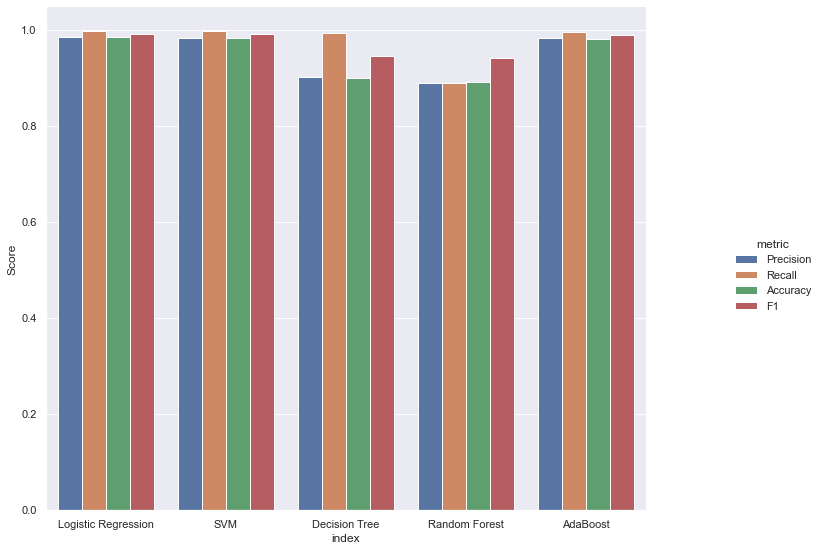

In [531]:
## Reset the index and melt the metric name column to make the data compatible with a seaborn multiple bar chart
model_scores_stacked = model_scores_df.reset_index(level=0)
model_scores_stacked = pd.melt(model_scores_stacked, id_vars="index", var_name="metric", value_name="Score")

## Generate our plot
g = sns.catplot(x='index', y='Score', hue='metric', data=model_scores_stacked, kind='bar')
g.fig.set_figwidth(12)
g.fig.set_figheight(8)


None of the models had any major failures. It seems like linear models like logistic regression and linear SVM perform better than tree based models. Since there was a significant class imbalance, accuracy was not an acceptable metric. It was still impressive to see such high accuracy scores in the Logistic Regression and SVM model.

An Adaptive Boosting model performed very well, but it did not perform any better than the Logistic Regression or SVM in any metric. Since the AdaBoost model was very computationally expensive (It took hours of runtime when the Logistic Regression took seconds), I reccomend using a Logistic Regression or SVM over it.

Precision, which measures what proportion of positive identifications are actually correct, is  sensitive to false positives. If an algorithm would incorrectly classify spam messeges as legitimate, then it would have a lower precision score. Recall, which measures what proportion of actual positives are identified correctly, is sensitive to false negatives. If an algorithm would incorrectly classify legitimate messeges as spam, then it would have a lower recall score. F1 is based off of the balance between precision and recall and in this case, both SVMs and Logistic Regressions had high f1s, indicading a good balance.

False negatives are what we want to avoid in the real-life application of a spam filtering algorithm. Getting spam can be annoying, but having a legitimate messege automatically flagged as spam can cause a lot of issues for someone in an email-heavy jobs. For that reason Recall becomes the best metric.

Since Recall is the best metric to use, the best suggested model is a Support Vector Machine, since it had the highest stratefied k-fold cross validated recall rate of 0.997, just narrowly beating logistic regression (having a recal rate of 0.996).

For this reason, it makes sense to employ a linear SVM (or logistic regresison) for messege classificatio on tfidf vectorized text data because it is fairly generalizable and it minimizes false negatives especially well while being an overall accurate model.